In [1]:
#Main presenting jupyter file

#import all necessary dependencies
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
BATCH_SIZE = 16
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
#from skimage.util.montage import montage2d as montage
#new version of skimage
from skimage.util import montage2d as montage
import cv2
import random
from datetime import datetime
import json
import gc

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import torch.backends.cudnn as cudnn
import torch.backends.cudnn
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision.transforms import ToTensor, Normalize, Compose
from U_Net_Main import UNet
from U_Net_Main import ShipDataset


from tqdm import tqdm
from pathlib import Path

from skimage.morphology import label

ship_dir = '/datasets/ee285f-public/airbus_ship_detection/'
train_image_dir = os.path.join(ship_dir, 'train_v2')
test_image_dir = os.path.join(ship_dir, 'test_v2')


def mask_overlay(image, mask, color=(0, 1, 0)):
    """
    Helper function to visualize mask on the top of the image
    """
    mask = np.dstack((mask, mask, mask)) * np.array(color)
    weighted_sum = cv2.addWeighted(mask, 0.5, image, 0.5, 0.)
    img = image.copy()
    ind = mask[:, :, 1] > 0
    img[ind] = weighted_sum[ind]    
    return img

def imshow(img, mask, title=None):
    """Imshow for Tensor."""
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    mask = mask.numpy().transpose((1, 2, 0))
    mask = np.clip(mask, 0, 1)
    fig = plt.figure(figsize = (6,6))
    plt.imshow(mask_overlay(img, mask))
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
def imshow_ori(img,title=None):
    """
    show original image with tensor
    """
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    #mask = mask.numpy().transpose((1, 2, 0))
    #mask = np.clip(mask, 0, 1)
    fig = plt.figure(figsize = (6,6))
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

    
def variable(x, volatile=False):
    if isinstance(x, (list, tuple)):
        return [variable(y, volatile=volatile) for y in x]
    return cuda(Variable(x, volatile=volatile))

def cuda(x):
    return x.cuda(async=True) if torch.cuda.is_available() else x

masks = pd.read_csv(os.path.join(ship_dir,
                                 '/datasets/ee285f-public/airbus_ship_detection/train_ship_segmentations_v2.csv'))
#masks = masks.iloc[10000:12000]
#masks.head()
masks = masks.drop(masks[masks.EncodedPixels.isnull()].sample(70000,random_state=42).index)

In [2]:
from sklearn.model_selection import train_test_split
unique_img_ids = masks.groupby('ImageId').size().reset_index(name='counts')
train_ids, valid_ids = train_test_split(unique_img_ids, 
                 test_size = 0.05, 
                 stratify = unique_img_ids['counts'],
                 random_state=42
                )
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
train_df['counts'] = train_df.apply(lambda c_row: c_row['counts'] if 
                                    isinstance(c_row['EncodedPixels'], str) else
                                    0, 1)
valid_df['counts'] = valid_df.apply(lambda c_row: c_row['counts'] if 
                                    isinstance(c_row['EncodedPixels'], str) else
                                    0, 1)
dataset_valid = ShipDataset(valid_df)


In [3]:
model = UNet()
model_path ='model_Random1.pt'
state = torch.load(str(model_path))
state = {key.replace('module.', ''): value for key, value in state['model'].items()}
model.load_state_dict(state)
if torch.cuda.is_available():
    model.cuda()

#model.eval()
valid_ds  = ShipDataset(valid_df)


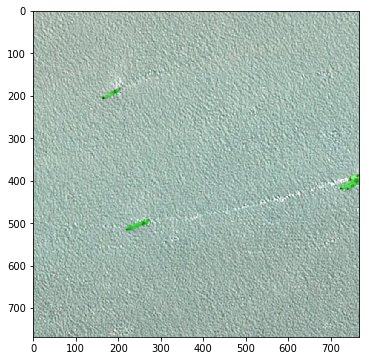

In [4]:
#show original image
imshow(*valid_ds[33])

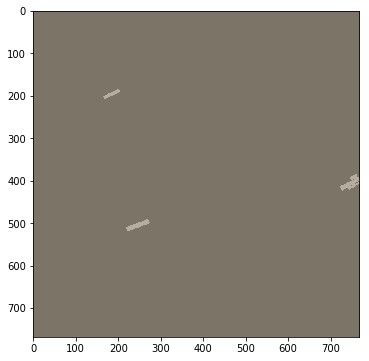

In [5]:
#show mask of orginal image
imshow_ori(valid_ds[33][1])

### Show predicted mask on validation set, there's a small color variation after adding the mask.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:92: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


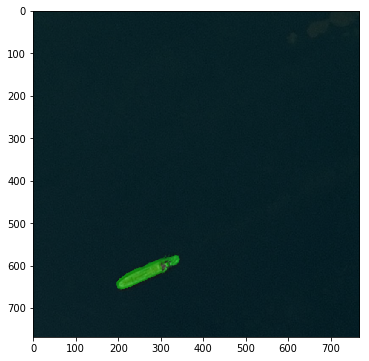

In [6]:
img,_ = valid_ds[61]
input_img = torch.unsqueeze(variable(img, volatile=True), dim=0)
mask = F.sigmoid(model(input_img))
out_mask = torch.squeeze(mask.data.cpu(), dim = 0)
imshow(img,out_mask)

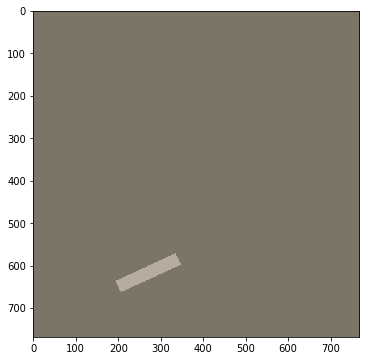

In [7]:
#the annotated original mask
imshow_ori(valid_ds[61][1])


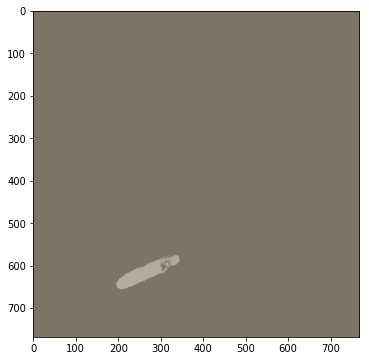

In [8]:
#show predicted mask
imshow_ori(out_mask)

In [9]:
loss=0
for i in range(100):
    img,ori_mask=valid_ds[i]
    
    input_img = torch.unsqueeze(variable(img, volatile=True), dim=0)
    mask = F.sigmoid(model(input_img))
    out_mask = torch.squeeze(mask.data.cpu(), dim = 0)
    
    given_array=np.array(ori_mask)
    test_array=np.array(out_mask)
    #set threshold to identify mask from backgroung, also this step is used to reduce color variation.
    test_array[test_array<0.7]=0
    test_array[test_array>=0.7]=1
    loss+=np.sum(np.abs((given_array-test_array)))/given_array.size
loss=loss/100
print('pixel wise binary loss on validation set is',loss)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:92: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


pixel wise binary loss on validation set is 0.0016943359375


### Show prediction results on Testset

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:92: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


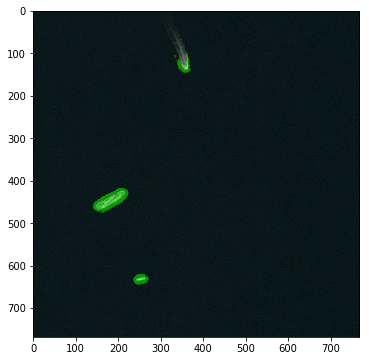

In [10]:
test_paths = os.listdir(test_image_dir)
test_df = pd.DataFrame({'ImageId': test_paths, 'EncodedPixels':None})
test_ds  = ShipDataset(test_df,mode='test')


img,_ = test_ds[47]
input_img = torch.unsqueeze(variable(img, volatile=True), dim=0)
mask = F.sigmoid(model(input_img))
out_mask = torch.squeeze(mask.data.cpu(), dim = 0)


imshow(img,out_mask)

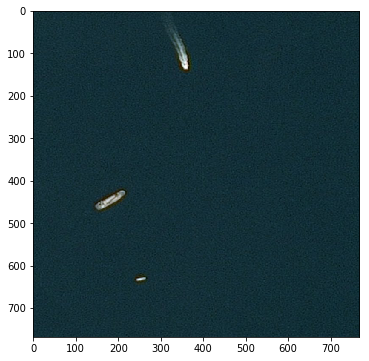

In [11]:
#show original image
img,_ = test_ds[47]
imshow_ori(img)